In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Imputed and reconstructed data vizualizations for PBMC

In [ ]:
from IPython import display
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import cm
from matplotlib.colors import Normalize 
from tensorflow import keras
import tensorflow as tf
import scipy.stats as stats
from tensorflow.keras import layers
import tensorflow_probability as tfp
from scipy.stats import gaussian_kde
import os

#Load Model
Root_Folder = "/content/drive/MyDrive" 

TypeOfdata =  'pbmc'
data_parent_folder = "/Data"
code_parent_folder = "/scMVI"

os.chdir('/content/drive/My Drive/' + code_parent_folder +'/Code')

Acc_test = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Acc_test_" + TypeOfdata +".pickle")
Rna_test = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Rna_test_" + TypeOfdata +".pickle")
Nrm_rna_test = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Nrm_rna_test_" + TypeOfdata +".pickle")
Nrm_acc_test = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Nrm_acc_test_" + TypeOfdata +".pickle")

Acc_tst = tf.convert_to_tensor(Acc_test,dtype=tf.float32)
Rna_tst = tf.convert_to_tensor(Rna_test,dtype=tf.float32)

Acc_nrm_tst = tf.math.log(tf.convert_to_tensor(Nrm_acc_test,dtype=tf.float32))
Rna_nrm_tst = tf.math.log(tf.convert_to_tensor(Nrm_rna_test,dtype=tf.float32))

Acc_nrm_tst = tf.repeat(Acc_nrm_tst,repeats=Acc_tst.shape[1],axis=1)
Rna_nrm_tst = tf.repeat(Rna_nrm_tst,repeats=Rna_tst.shape[1],axis=1)

inp_sz_acc=Acc_tst.shape[1]
inp_sz_rna=Rna_tst.shape[1]

In [ ]:
if TypeOfdata == "pbmc":

                  ind_sub = np.asarray(np.random.permutation(2955),dtype=np.int32)
                  aa=5 #Downsampling cells
                  Acc_tst = tf.gather(Acc_tst,ind_sub[:aa],axis=0)
                  Rna_tst = tf.gather(Rna_tst,ind_sub[:aa],axis=0)
                  Acc_nrm_tst = tf.gather(Acc_nrm_tst,ind_sub[:aa],axis=0)
                  Rna_nrm_tst = tf.gather(Rna_nrm_tst,ind_sub[:aa],axis=0)

def find_ind(Acc_dat,Rna_dat):
    avg_acc=tf.reduce_mean(Acc_dat,axis=1)
    avg_exp=tf.reduce_mean(Rna_dat,axis=1)

    acc_ind_zer = tf.where(avg_acc==0)
    rna_ind_zer = tf.where(avg_exp==0)
    acc_ind_nzer = tf.where(avg_acc>0)
    rna_ind_nzer = tf.where(avg_exp>0)

    cells_acc_mod=np.intersect1d(acc_ind_nzer,rna_ind_zer)
    cells_jt_mod=np.intersect1d(acc_ind_nzer,rna_ind_nzer)
    cells_rna_mod=np.intersect1d(acc_ind_zer,rna_ind_nzer)

    return cells_acc_mod,cells_rna_mod,cells_jt_mod

_,_,ind_jt_tst = find_ind(Acc_tst,Rna_tst)


In [ ]:
#Estimate uncertainty for reconstruced or imputed samples
def est_std(x):
    x = tf.stack(x,axis=0)
    x = tfp.stats.stddev(x,sample_axis=0)
    return x

def data_uncertainty(model,xx,num_samps):
    col_smps_acc = []
    col_smps_rna = []
    col_imp_smps_acc = []
    col_imp_smps_rna = []
    for ii in range(num_samps):

          Acc_pred,Rna_acc_pred = mdl.imp_cells(xx,'acc')
          Acc_rna_pred,Rna_pred = mdl.imp_cells(xx,'rna')

          col_smps_acc.append(tf.math.log(1+Acc_pred))
          col_smps_rna.append(tf.math.log(1+Rna_pred))
          
          col_imp_smps_acc.append(tf.math.log(1+Acc_rna_pred))
          col_imp_smps_rna.append(tf.math.log(1+Rna_acc_pred))    
    
    smps_std = [est_std(col_smps_acc),est_std(col_smps_rna)]
    imp_smps_std = [est_std(col_imp_smps_acc),est_std(col_imp_smps_rna)]

    data_rec = [tf.math.log(1+Acc_pred),tf.math.log(1+Rna_pred)]
    data_imp = [tf.math.log(1+Acc_rna_pred),tf.math.log(1+Rna_acc_pred)]

    return data_rec,smps_std,data_imp,imp_smps_std

In [ ]:
from Models import scMVI_10X
from Obj_Blocks import *
from Plotting import *

In [ ]:
#Define model and load weights for the trained model
mdl = scMVI_10X(inp_acc_dim=inp_sz_acc,inp_rna_dim=inp_sz_rna,intermidiate_dim=100,latent_dimensions=10)
mdl.load_weights(Root_Folder + code_parent_folder + "/Networks/scMVI_10X_"+TypeOfdata+"/scMVI_10X_"+TypeOfdata)

In [ ]:
smps,smps_std,smps_imp,smps_imp_std = data_uncertainty(mdl,[Acc_tst,Acc_nrm_tst,Rna_tst,Rna_nrm_tst],4)
Acc_pred_tst,Rna_pred_tst = smps
Acc_rna_pred_tst,Rna_acc_pred_tst = smps_imp

Acc_pred_tst_std,Rna_pred_tst_std = smps_std
Acc_rna_pred_tst_std, Rna_acc_pred_tst_std = smps_imp_std

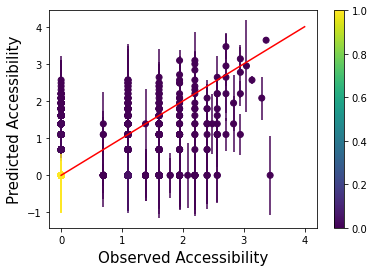

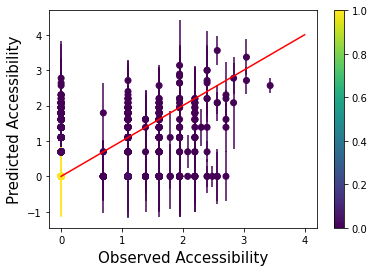

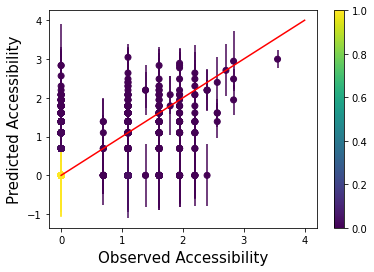

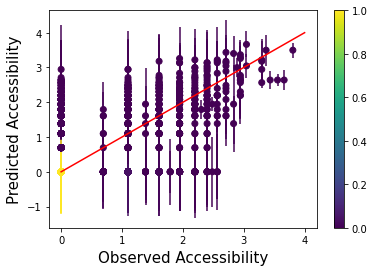

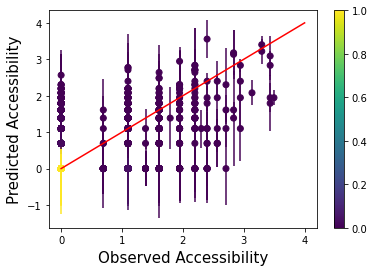

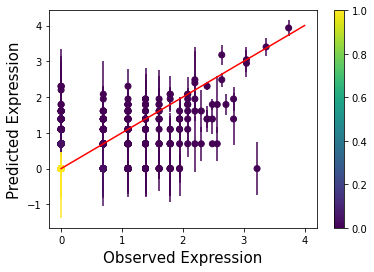

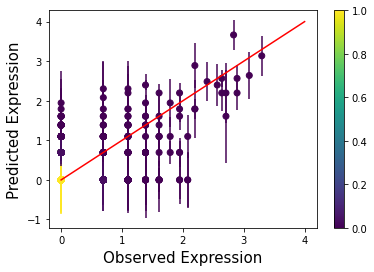

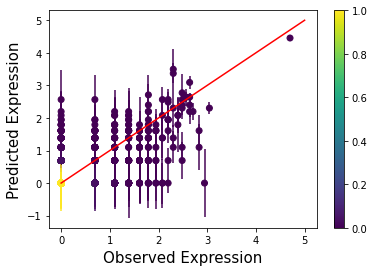

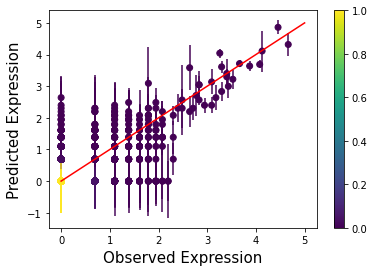

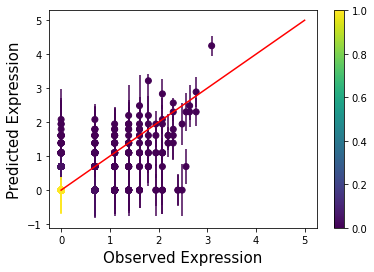

In [ ]:
aaa = ind_jt_tst
for ii in range(5):

          plt = density_scatter_plot(tf.math.log(1+Acc_tst[aaa[ii],:]),Acc_pred_tst[aaa[ii],:],0.0*Acc_pred_tst_std[aaa[ii],:]) 
          plt.ylabel("Predicted Accessibility", labelpad = 5,fontsize=15)
          plt.xlabel("Observed Accessibility", labelpad = 5,fontsize=15)
          #plt.savefig(Root_Folder + code_parent_folder + "/Paper_Plots/Acc_"+TypeOfdata+"_rec_"+str(ii)+".png")
          plt.show()

for ii in range(5):

          plt = density_scatter_plot(tf.math.log(1+Rna_tst[aaa[ii],:]),Rna_pred_tst[aaa[ii],:],0.0*Rna_pred_tst_std[aaa[ii],:]) 
          plt.ylabel("Predicted Expression", labelpad = 5,fontsize=15)
          plt.xlabel("Observed Expression", labelpad = 5,fontsize=15)
          #plt.savefig(Root_Folder + code_parent_folder + "/Paper_Plots/Rna_"+TypeOfdata+"_rec_"+str(ii)+".png")
          plt.show()

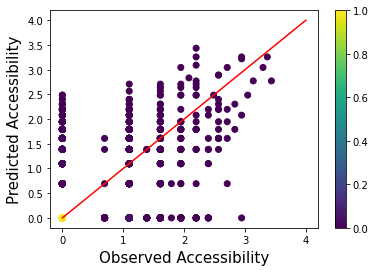

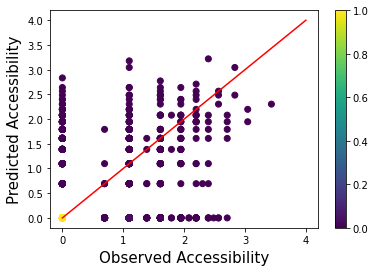

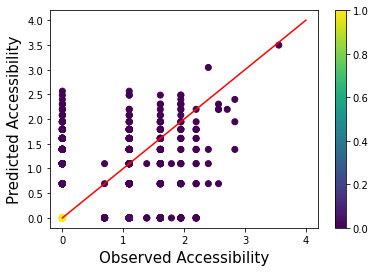

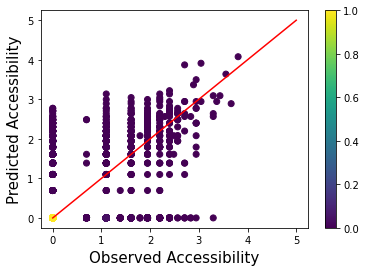

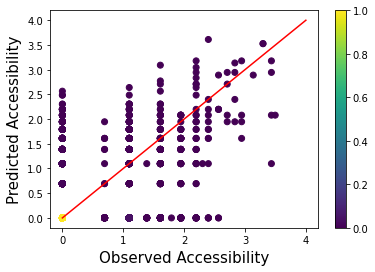

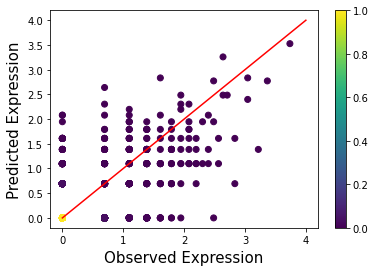

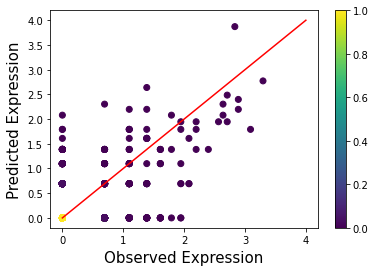

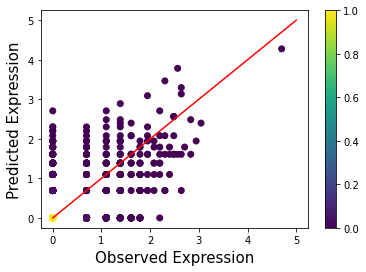

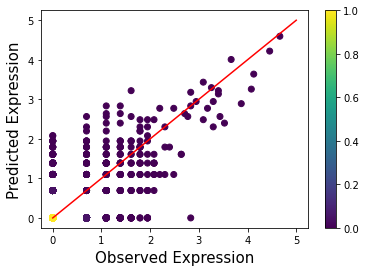

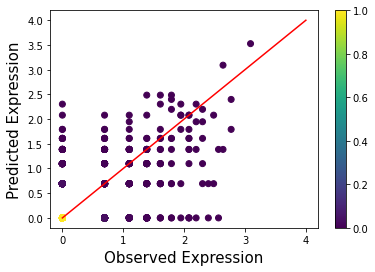

In [ ]:
aaa = ind_jt_tst

for ii in range(5):
          plt = density_scatter_plot(tf.math.log(1+Acc_tst[aaa[ii],:]),Acc_rna_pred_tst[aaa[ii],:],0.0*Acc_rna_pred_tst_std[aaa[ii],:]) 
          plt.ylabel("Predicted Accessibility", labelpad = 5,fontsize=15)
          plt.xlabel("Observed Accessibility", labelpad = 5,fontsize=15)
          #plt.savefig(Root_Folder + code_parent_folder + "/Paper_Plots/Acc_rna_"+TypeOfdata+"_imp_"+str(ii)+".png")
          plt.show()


for ii in range(5):
          plt = density_scatter_plot(tf.math.log(1+Rna_tst[aaa[ii],:]),Rna_acc_pred_tst[aaa[ii],:],0.0*Rna_acc_pred_tst_std[aaa[ii],:]) 
          plt.ylabel("Predicted Expression", labelpad = 5,fontsize=15)
          plt.xlabel("Observed Expression", labelpad = 5,fontsize=15)
          #plt.savefig(Root_Folder + code_parent_folder + "/Paper_Plots/Rna_acc_"+TypeOfdata+"_imp_"+str(ii)+".png")
          plt.show()